# GlassAI data

This notebook explores data obtained from GlassAI

I want to understand the data.
* Key variables (to document)
* Questions for them
* Interesting questions we could explore with these data
* Validation vs official data by sector

...



## Preamble

In [387]:
%matplotlib inline
#Imports

#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data (to download the GRID database)
ext_data = os.path.join(top,'data/external')

#Interim data (to place seed etc)
int_data = os.path.join(top,'data/interim/')

#Figures
fig_path = os.path.join(top,'reports/figures')

#Models
mod_path = os.path.join(top,'models/')

#Visualisations
viz_path = os.path.join(top,'src/visualization')


#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

In [388]:
import string
digits = string.digits

In [389]:
#Functions

def create_lq_df(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(lqs)

## 1. Load data


In [390]:
#Read Glass AI data
#Read and lowercase columns
glai_columns= [x.lower() for x in ['id','name','GeneratedSector','GeneratedSubsector','GeneratedTag',
          'SourceSector','SourceSubsector','Status','PredictedSector','Topics','PostalTowns','Website']]

data = pd.read_csv(ext_data+'/org_creative_by_subsectors_v2.txt',sep='\t',header=None)
data.columns=glai_columns

In [391]:
#Shape
#Around 253K companies. How does this compare with the CN data?
data.shape

(253650, 12)

In [392]:
#Get value counts for categorical variables
value_counts = [[x,data.loc[:,x].value_counts()] for x in glai_columns if len(set(data.loc[:,x]))<100]

#And print them
for x in value_counts:
    print(x[0])
    print('====')
    print(x[1])
    print('\n')


generatedsector
====
Media and Arts                  77180
Technology                      77106
Professional Services           65311
Consumer Goods and Services     21948
Real Estate and Construction    11123
Non Profit and Education          982
Name: generatedsector, dtype: int64


generatedsubsector
====
Information Technology and Services    34025
Marketing and Advertising              30885
Design                                 26894
Internet                               25471
Computer Software                      15369
Apparel and Fashion                    13128
Music                                  12745
Arts and Crafts                        12477
Architecture and Planning              11123
Photography                             9983
Newspapers and Magazines                8892
Luxury Goods and Jewellery              8820
Media Production                        8262
Publishing                              7190
Motion Pictures and Film                5004
Broadcast Medi

Some initial questions:
* Why aren't there any 'R2' in the list
* What is the difference between sourcesector and generated sector?
* What do U and C mean?

In [393]:
#Check the topics

#Split them into lists of topics unless they are nan
data['topics_list'] = [x.split(",") if type(x)==str else [] for x in data.topics]

#How many companies with missing topics do we have?
np.sum([len(x)==0 for x in data.topics_list])/len(data)

0.55052631578947364

We have topics for 45% of the companies in the dataset. 

In [394]:
data['has_topic'] = [len(x)>0 for x in data.topics_list]

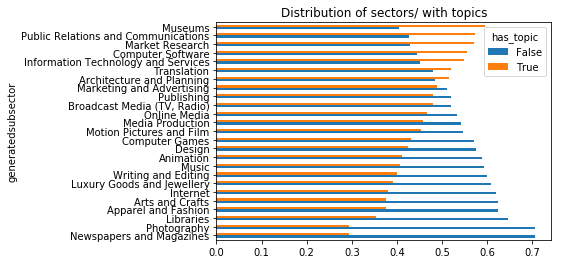

In [395]:
#Plot
pd.crosstab(data['has_topic'],
            data['generatedsubsector'],normalize=1).T.sort_values(True).plot.barh(title='Distribution of sectors/ with topics')

In [396]:
#What are the top topics (and by sector)

all_topics_distr = pd.Series([x for el in data.topics_list for x in el]).value_counts(ascending=False)

#They seem to pick up popular ngrams
all_topics_distr[:25]

#Create a share of all topics variable we can use to normalise inside subsectors (a bit like tfidf)
all_topics_share = pd.DataFrame(all_topics_distr/all_topics_distr.sum())
all_topics_share.columns=['share_all']

In [397]:
#Get top topics by sector
#NB we are normalising to find relevant topics

top_keywords_by_sector = data.groupby('generatedsubsector')['topics_list'].apply(lambda x: pd.Series(
    [t for el in x for t in el]).value_counts(ascending=False)).reset_index(drop=False)

for x in set(top_keywords_by_sector.generatedsubsector):
    print(x)
    print('='*len(x))
    
    topics_in_sector = top_keywords_by_sector.loc[
        top_keywords_by_sector.generatedsubsector==x,[
            'level_1','topics_list']].set_index('level_1').sort_values('topics_list',ascending=False)[:25]
    
    
    topics_in_sector['share_in_sector'] = topics_in_sector/topics_in_sector.sum()
    
    topics_in_sector_norm = topics_in_sector.join(all_topics_share)
    
    topics_in_sector_norm['share_norm'] = topics_in_sector_norm['share_in_sector']/topics_in_sector_norm['share_all']
    
    print(topics_in_sector_norm.sort_values('share_norm',ascending=False)[:10])
    
    
    
    #print(top_keywords_by_sector.loc[top_keywords_by_sector.generatedsubsector==x,['level_1','topics_list']])
    print('\n')

Design
                    topics_list  share_in_sector  share_all  share_norm
level_1                                                                
kitchen design               85         0.041585   0.000157  264.621047
bespoke kitchen              45         0.022016   0.000091  241.979674
garden design               143         0.069961   0.000313  223.770739
soft furnishings             47         0.022994   0.000117  195.780112
design consultancy          115         0.056262   0.000293  192.155862
bespoke furniture            43         0.021037   0.000111  189.811585
interior design             298         0.145793   0.000782  186.330602
garden designer              43         0.021037   0.000116  181.676803
interior designers           42         0.020548   0.000116  177.451761
logo design                  64         0.031311   0.000192  163.174033


Luxury Goods and Jewellery
                   topics_list  share_in_sector  share_all  share_norm
level_1                      

In [398]:
#What about the 'postal cities'?
#For how many do we have data?

#We only have addresses for ~ half of the data
np.sum(data.postaltowns.isnull())/len(data)

0.50386359156317762

In [399]:
#Create list of postaltowns

data['towns_list'] = [[t.lower() for t in x.split(',')] if type(x)==str else [] for x in data.postaltowns]

print(pd.Series([len(x) for x in data['towns_list']]).describe())

count    253650.000000
mean          3.902168
std         157.204638
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max       43592.000000
dtype: float64


In [400]:
#There are a few companies with LOTS of addresses

data.loc[[len(x)>500 for x in data['towns_list']],:][:10]

,id,name,generatedsector,generatedsubsector,generatedtag,sourcesector,sourcesubsector,status,predictedsector,topics,postaltowns,website,topics_list,has_topic,towns_list
2518,733376,Twizoo,Technology,Internet,R1,Technology,Internet,U,"Technology:Internet:29.1000708347,Professional...",social content,"E1 1BY,E1 4AA,E1 4LJ,E1 4LR,E1 4TT,E1 4UN,E1 6...",twizoo.com,[social content],True,"[e1 1by, e1 4aa, e1 4lj, e1 4lr, e1 4tt, e1 4u..."
3933,224376,Surrey Mirror,Media and Arts,Newspapers and Magazines,R1,Media and Arts,Newspapers and Magazines,U,Non Profit and Education:Charities and Foundat...,"private network,recruitment team,religious den...","BR1 1NN,BR1 1NZ,BR1 1PQ,BR1 2EX,BR1 3EL,BR1 3P...",www.getsurrey.co.uk/all-about/reigate,"[private network, recruitment team, religious ...",True,"[br1 1nn, br1 1nz, br1 1pq, br1 2ex, br1 3el, ..."
6002,707279,mtvan.com,Technology,Information Technology and Services,R1,Technology,Information Technology and Services,U,Technology:Information Technology and Services...,courier companies,"AB12 4YA,AB42 3JF,AB51 0GQ,AL10 9NE,AL7 3AX,B1...",www.mtvan.com,[courier companies],True,"[ab12 4ya, ab42 3jf, ab51 0gq, al10 9ne, al7 3..."
6074,173216,Lakeland Walker,Media and Arts,Newspapers and Magazines,R1,Media and Arts,Newspapers and Magazines,U,Non Profit and Education:Charities and Foundat...,"read full,caravan holiday,new caravan,customer...","AB21 0EY,AB34 4UP,AB38 9LD,AB38 9SL,AB53 5TA,A...",www.outandaboutlive.co.uk,"[read full, caravan holiday, new caravan, cust...",True,"[ab21 0ey, ab34 4up, ab38 9ld, ab38 9sl, ab53 ..."
6189,200356,Runcorn World,Media and Arts,Newspapers and Magazines,R1,Media and Arts,Newspapers and Magazines,U,Media and Arts:Newspapers and Magazines:40.272...,"well done,select security","AL10 9NE,B1 1BB,B4 6LJ,B46 1JY,BA22 8HZ,BB1 1R...",www.runcornandwidnesworld.co.uk,"[well done, select security]",True,"[al10 9ne, b1 1bb, b4 6lj, b46 1jy, ba22 8hz, ..."
6550,32177,Building Products Index,Media and Arts,Publishing,R1,Media and Arts,Publishing,U,"Media and Arts:Publishing:39.0203662038,Real E...","waste management,stainless steel,surface water...","AB10 1AB,AB10 7LH,AB11 6HA,AB11 9AA,AB12 3LF,A...",www.bpindex.co.uk,"[waste management, stainless steel, surface wa...",True,"[ab10 1ab, ab10 7lh, ab11 6ha, ab11 9aa, ab12 ..."
6562,136055,LeftLion,Media and Arts,Publishing,R1,Media and Arts,Publishing,U,Non Profit and Education:Charities and Foundat...,"recreation ground,early bird,dedicated music,s...","B40 1NT,B72 1RJ,B98 8BP,BN21 3UH,CV2 2ST,DE1 3...",www.leftlion.co.uk,"[recreation ground, early bird, dedicated musi...",True,"[b40 1nt, b72 1rj, b98 8bp, bn21 3uh, cv2 2st,..."
6737,701917,Lionheart Media Network,Media and Arts,Newspapers and Magazines,R1,Media and Arts,Newspapers and Magazines,U,Media and Arts:Newspapers and Magazines:26.026...,"annual return,active company,confirmation stat...","AB10 1DQ,AB10 1HA,AB10 1PS,AB10 1SL,AB10 1YL,A...",suite.endole.co.uk/insight/company/09243817-li...,"[annual return, active company, confirmation s...",True,"[ab10 1dq, ab10 1ha, ab10 1ps, ab10 1sl, ab10 ..."
6875,251245,Wakefield Express,Media and Arts,Newspapers and Magazines,R1,Media and Arts,Newspapers and Magazines,U,Non Profit and Education:Charities and Foundat...,admiral nurse,"BD11 1AU,BD5 8HW,BD8 7HB,DN1 1TN,EC4M 7LG,HD9 ...",www.wakefieldexpress.co.uk,[admiral nurse],True,"[bd11 1au, bd5 8hw, bd8 7hb, dn1 1tn, ec4m 7lg..."
6889,132844,KweekWeek,Technology,Internet,R1,Technology,Internet,U,Non Profit and Education:Charities and Foundat...,"outdoor garden,book tickets,business concept,u...","B36 8RE,BS13 7HP,CM14 5QS,CM2 8WQ,CM3 5WP,CV23...",www.kweekweek.com,"[outdoor garden, book tickets, business concep...",True,"[b36 8re, bs13 7hp, cm14 5qs, cm2 8wq, cm3 5wp..."


This seems to be picking up losts of directories / newspapapers / online sites for mapping (?)

In [401]:
#What are the most popular towns?

pd.Series([x for el in data['towns_list'] for x in el]).value_counts(ascending=False)[:20]

ip14 1dt    3476
ec1v 2nx     410
n1 7gu       386
ec2a 4ne     386
w14 8ux      290
wc2h 9jq     284
w1b 3hh      275
e1 6ql       246
ec1v 4pw     244
e16 1xl      242
wc2r 1la     232
n1 0qh       220
se1 8xx      196
dublin 2     195
ec1v 4py     193
ec4m 7lg     190
ec2a 3ay     181
b40 1nt      175
ec2a 4bx     172
ec2y 8ds     163
dtype: int64

In [402]:
#Rename columns
data.columns = ['id','name','creative_glai_sector','creative_glai_subsector','source',
                'source_glai_sector','source_glai_subsector','status','sector_probabilities','topics','postcodes',
               'website','topics_list','has_topics','postcode_list']

#Drop irrelevant columns
data.drop(['status','topics','postcodes','has_topics'],axis=1,inplace=True)

## 2. Explore and enrich data

* Rename and document data
* Decide what to do about companies with mixed sectors
* Obtain postcodes and assign companies to a single location
* Develop a protocol to assign companies to sectors and validate vs official data
 * Use the lookup. Challenge = There are a couple of sectors with more than one 

In [403]:
#Load metadata for all this enrichment

#Load NSPL data
nspl = pd.read_csv(ext_data+'/NSPL_AUG_2017_UK/Data/NSPL_AUG_2017_UK.csv',
                   usecols=['pcds','ttwa','laua','gor']
                  )

ttwa_labels = pd.read_csv(ext_data+'/NSPL_AUG_2017_UK/Documents/TTWA names and codes UK as at 12_11 v5.txt',
                          delimiter='\t')

ttwa_labels.rename(columns={'TTWA11CD':'ttwa_code','TTWA11NM':'ttwa_name'},inplace=True)


#Load the GlassAI - DCMS lookup and lowercase columns
glai_dcms_lookup = pd.read_excel(ext_data+'/glass_ai_dcms_lookup.xlsx',sheetname=1)
glai_dcms_lookup.columns = [x.lower() for x in glai_dcms_lookup.columns]

glai_dcms_lookup.rename(columns={'creative_sector':'dcms_sector'},inplace=True)


In [404]:
#We want to drop companies with lots of postcodes
postcodes_n = pd.Series([len(x) for x in data.postcode_list])

postcodes_n.value_counts()/len(postcodes_n)

#If we drop all companies with more than 5 postcodes this amounts to 4% of the data.

100*np.sum(postcodes_n>5)/len(postcodes_n)

#Subset the data to focus on companies with few addresses, and identify the top address
data_subset = data[postcodes_n<=5]

#Here is the top address
data_subset['postcode_top'] = [x[0].strip() if len(x)>0 else np.nan for x in data_subset.postcode_list]

#Merge with nspl

nspl['pcds']=[x.lower() for x in nspl['pcds']]

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [406]:
#There is a small number of missing postcodes.
#Some of them seem postboxes
missing_postcodes = set(data_subset['postcode_top'].dropna()) - set(nspl['pcds'])

np.sum([x[0] in digits for x in missing_postcodes])

261

In [407]:
#Let's work with these
#Merge
data_subset = pd.merge(pd.merge(data_subset,nspl,left_on='postcode_top',right_on='pcds',how='left'),
                       ttwa_labels,left_on='ttwa',right_on='ttwa_code')
                       
#Now get the sectors
data_labelled = pd.merge(data_subset,
                        glai_dcms_lookup,left_on='creative_glai_subsector',right_on='subsector')


data_labelled['has_top_subsector'] = [x==y for x,y in zip(data_labelled.creative_glai_subsector,
                                                          data_labelled.source_glai_subsector)]

In [408]:
data_labelled.drop('observation',axis=1,inplace=True)

In [418]:
#Sector totals (all observations)
glass_ai_sector_totals = data_labelled.dcms_sector.value_counts()
glass_ai_sector_totals.name = 'glass_ai_creative_all'

#Sector totals (high q observations)
glass_ai_sector_totals_high_q = data_labelled.loc[data_labelled.source=='R1','dcms_sector'].value_counts()
glass_ai_sector_totals_high_q.name = 'glass_ai_creative_r1'

#sector totals (perfect matches)
glass_ai_sector_totals_perf_match = data_labelled.loc[
    data_labelled.has_top_subsector==True,'dcms_sector'].value_counts()

glass_ai_sector_totals_perf_match.name = 'glass_ai_creative_top_match'


In [419]:
#Let's do a comparison with the IDBR data

#First, create a name lookup so we can merge easily

dcms_names_lookup = {
    'IT, software and computer services':'it_software',
    'Music, performing and visual arts':'music_performing_arts',
    'Film, TV, video, radio and photography':'video_film_photography',
    'Advertising and marketing':'advertising_marketing',
    'Design':'design',
    'Architecture':'architecture',
    'Publishing':'publishing',
    'Museums, galleries and libraries':'libraries_museums',
    'Crafts':'crafts',
    'not_in_sector':'not_in_sector',
    'creative_industries':'creative_industries'}



In [420]:
#Load IDBR data
idbr_totals = pd.read_csv(int_data+'/5_11_2017_idbr_totals.csv')

#Extract totals (with clean mname)
idbr_totals['sector_clean'] = [dcms_names_lookup[x] for x in idbr_totals.sector]
idbr_totals_2016 = idbr_totals.loc[
    idbr_totals.year==2016,:].groupby('sector_clean')['value'].sum().sort_values(ascending=False)

In [421]:
idbr_glass_ai = pd.concat([idbr_totals_2016,glass_ai_sector_totals,glass_ai_sector_totals_high_q,
                          glass_ai_sector_totals_perf_match],axis=1)

idbr_glass_ai['glass_ai_coverage_all'] = idbr_glass_ai['glass_ai_creative_all']/idbr_glass_ai['value']
idbr_glass_ai['glass_ai_coverage_r1'] = idbr_glass_ai['glass_ai_creative_r1']/idbr_glass_ai['value']
idbr_glass_ai['glass_ai_coverage_p'] = idbr_glass_ai['glass_ai_creative_top_match']/idbr_glass_ai['value']
idbr_glass_ai['glass_ai_r1_ratio'] = idbr_glass_ai['glass_ai_creative_r1']/idbr_glass_ai['glass_ai_creative_all']

idbr_glass_ai

,value,glass_ai_creative_all,glass_ai_creative_r1,glass_ai_creative_top_match,glass_ai_coverage_all,glass_ai_coverage_r1,glass_ai_coverage_p,glass_ai_r1_ratio
advertising_marketing,23965,18163.0,12105.0,8222.0,0.757897,0.505112,0.343084,0.666465
architecture,15805,6195.0,3873.0,2926.0,0.391965,0.245049,0.185131,0.625182
crafts,1245,3873.0,1892.0,826.0,3.110843,1.519679,0.663454,0.488510
creative_industries,280970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
design,22080,12431.0,7030.0,4623.0,0.562998,0.318388,0.209375,0.565522
it_software,136570,37655.0,22589.0,15525.0,0.275719,0.165402,0.113678,0.599894
libraries_museums,4115,541.0,508.0,501.0,0.131470,0.123451,0.121750,0.939002
music_performing_arts,33900,9659.0,4445.0,1863.0,0.284926,0.131121,0.054956,0.460193
not_in_sector,2623885,NaN,NaN,NaN,NaN,NaN,NaN,NaN
publishing,10990,9814.0,3470.0,2031.0,0.892994,0.315742,0.184804,0.353577


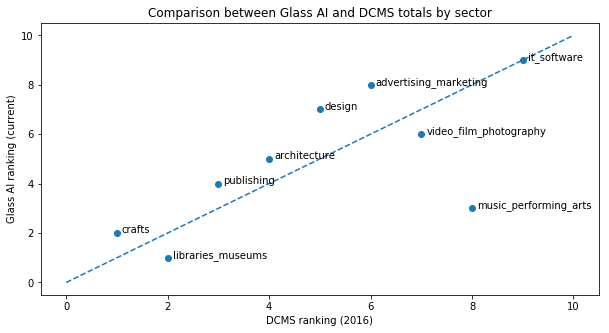

In [423]:
#Visualise differences in rankings

fig,ax = plt.subplots(figsize=(10,5))

#This is giving us the rank of each sector in each dataset
data_ranked = [idbr_glass_ai[x].rank() for x in ['value','glass_ai_creative_top_match']]

#This list contains sector names for plotting
var_names = idbr_glass_ai.index

#Create scatter
ax.scatter(data_ranked[0],data_ranked[1])

#Add text labels to points
for num,val in enumerate(np.arange(len(var_names))):
    ax.annotate(var_names[num],(data_ranked[0][num]+0.1,data_ranked[1][num]))

#Add a 1-1 line
ax.plot(np.arange(len(var_names)),np.arange(len(var_names)),linestyle='dashed')
    
#Add titles
ax.set_title('Comparison between Glass AI and DCMS totals by sector')
ax.set_xlabel('DCMS ranking (2016)')
ax.set_ylabel('Glass AI ranking (current)')

Glass AI data seems to have better coverage of B2B businesses like advertising and design

In [453]:
#Create a couple of validation functions
def generate_spec_lq(df,filter_variable=None,filter_value=None,spec_name='unfiltered_lq'):
    '''
    This function generates a specialisation DF based on different filters 
    #(we use those with Glass AI data to validate vs IDBR)
    '''
    
    if filter_variable!=None:
        df = df.loc[df[filter_variable]==filter_value,:]
    
    #Group
    df_grouped = df.groupby(
            ['ttwa_name','dcms_sector']).size().reset_index(drop=False)
    df_grouped.rename(columns={0:'business_count'},inplace=True)
        
    #Create LQs by sector (inside the CIs)
    df_lq = create_lq_df(pd.pivot_table(df_grouped,index='ttwa_name',columns='dcms_sector',
                                     values='business_count',aggfunc='sum').fillna(value=0))

    #Melt for merging later
    df_spec = pd.melt(df_lq.reset_index(drop=False),
                                 id_vars='ttwa_name',value_name=spec_name).set_index(['ttwa_name','dcms_sector'])
    
    return(df_spec)
 

def get_validation_charts(df,var_1,var_2,ax,col,name=None):
    '''
    This function creates a set of figures of the relationship between two variables,
    one of which will be the GlassAI data we want to validate.
    
    '''
    
    for num,x in enumerate(sorted(set(spec_comparison.dcms_sector))):
        data = df.loc[df.dcms_sector==x,:]

        cor = np.round(data.loc[:,[var_1,var_2]].apply(lambda x: np.log(x),axis=1).corr('spearman').iloc[0,1],2)


        ax[num][col].scatter(np.log(data[var_1]),np.log(data[var_2]),alpha=0.8)
        ax[num][col].set_title('Specialisation comparison for \n {sector} \n corr={cor}'.format(
            sector=x,cor=cor))
        ax[num][col].set_xlabel(var_1)
        ax[num][col].set_ylabel(var_2)
    
        

    

    
    

In [454]:
#Produce spec metrics
glass_ai_spec_all = generate_spec_lq(data_labelled)
glass_ai_spec_r1 = generate_spec_lq(data_labelled,filter_variable='source',filter_value='R1',spec_name='r1_lq')
glass_ai_spec_match = generate_spec_lq(data_labelled,filter_variable='has_top_subsector',filter_value=True,
                                      spec_name='top_match_lq')


#Concatenate results
glass_ai_results = pd.concat([glass_ai_spec_all,glass_ai_spec_r1,glass_ai_spec_match],axis=1).reset_index(drop=False)
glass_ai_results.loc[:,['lq' in x for x in glass_ai_results.columns]].corr()

,unfiltered_lq,r1_lq,top_match_lq
unfiltered_lq,1.000000,0.862750,0.728948
r1_lq,0.862750,1.000000,0.879899
top_match_lq,0.728948,0.879899,1.000000


In [455]:
#Generate IDBR specialisation profile
idbr_vars = [x for x in set(idbr_totals.sector_clean) if x in set(data_labelled.dcms_sector)]

idbr_total_lq = create_lq_df(pd.pivot_table(idbr_totals.loc[
    (idbr_totals.year==2016) & ([x in idbr_vars for x in idbr_totals.sector_clean]),].groupby(
    ['ttwa_name','sector_clean'])['value'].sum().reset_index(drop=False),index='ttwa_name',columns='sector_clean',
                                   values='value',aggfunc='sum'))

idbr_creative_spec = pd.melt(idbr_total_lq.reset_index(drop=False),
                            id_vars='ttwa_name',value_name='idbr_lq')

#Merge on ttwa-name and sector clean
spec_comparison = pd.merge(glass_ai_results,idbr_creative_spec,
                          left_on=['ttwa_name','dcms_sector'],right_on=['ttwa_name','sector_clean']).dropna()



/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log


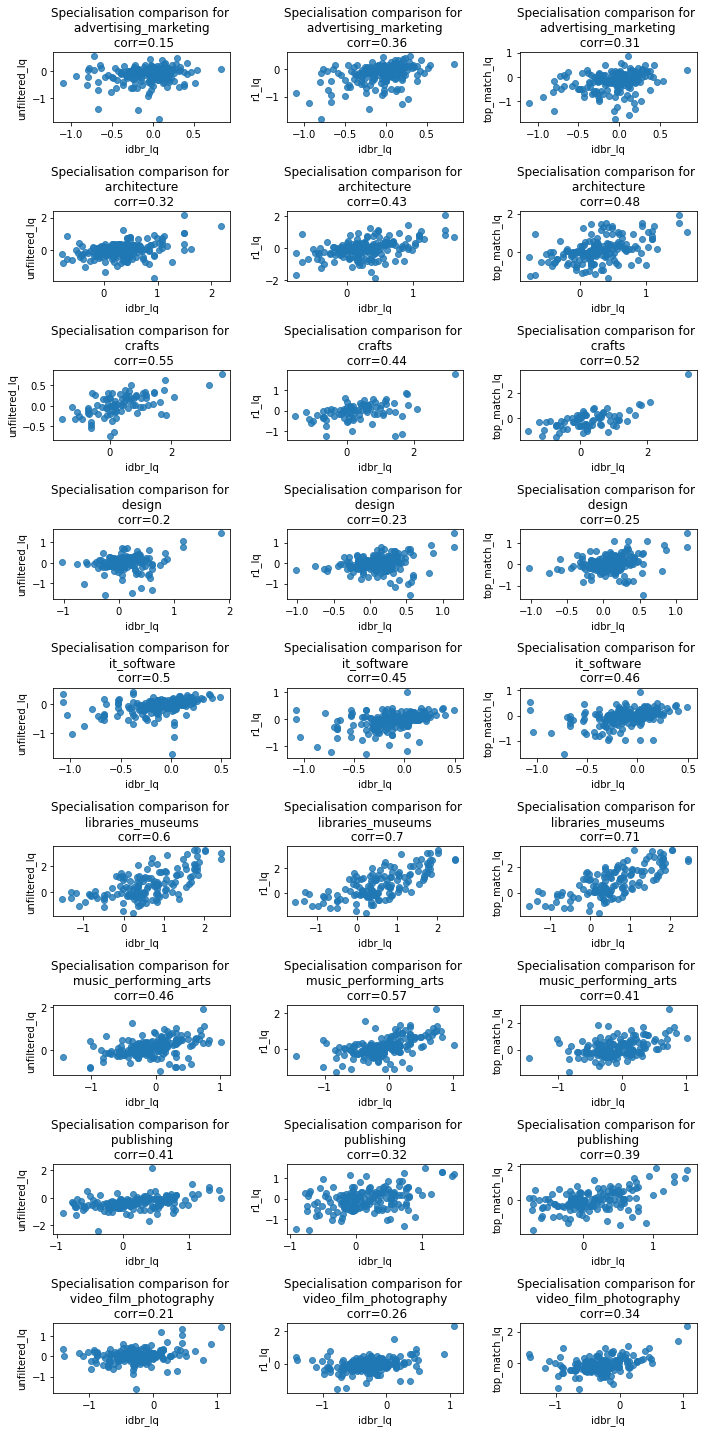

In [456]:
#Let's plot by sector

#Create a bunch of axes
fig,ax = plt.subplots(nrows=len(set(spec_comparison.dcms_sector)),ncols=3,
                     figsize=(10,20))

get_validation_charts(spec_comparison,'idbr_lq','unfiltered_lq',ax,col=0)
get_validation_charts(spec_comparison,'idbr_lq','r1_lq',ax,col=1)
get_validation_charts(spec_comparison,'idbr_lq','top_match_lq',ax,col=2)

plt.tight_layout()

Filtering affects the quality of the GlassAI match in different ways - although in general it improves it,
with the exception of IT. NB big improvement in advertising, perhaps because the topics are picking up other sectors?

In [ ]:
#Interestingly, the best correlation is for Museums, which was identified based on topics. 
#Could we do something similar for other sectors?

#Next steps

#Redo the analysis but classifying businesses into sectors based on their top variable#
#Identify the top labels inside each sector


In [468]:
def get_distinctive_topics(df):
    '''
    This function gets distinctive topics in sectors. We can subset them in different ways 
    
    '''
    
    distinctive_topics_in_sector=[]

    top_keywords_by_sector = df.groupby('dcms_sector')['topics_list'].apply(
        lambda x: pd.Series([t for el in x for t in el]).value_counts(ascending=False)).reset_index(drop=False)

    for x in set(top_keywords_by_sector.dcms_sector):
        print(x)
        print('='*len(x))
    
        topics_in_sector = top_keywords_by_sector.loc[
            top_keywords_by_sector.dcms_sector==x,[
                'level_1','topics_list']].set_index('level_1').sort_values('topics_list',ascending=False)[:50]


        topics_in_sector['share_in_sector'] = topics_in_sector/topics_in_sector.sum()

        topics_in_sector_norm = topics_in_sector.join(all_topics_share)

        topics_in_sector_norm['share_norm'] = topics_in_sector_norm['share_in_sector']/topics_in_sector_norm['share_all']

        print(topics_in_sector_norm.sort_values('share_norm',ascending=False)[:10])
        
        print('\n')

    distinctive_topics_in_sector.append(
        [x,topics_in_sector_norm.sort_values('share_norm',ascending=False)[:50]])
    
    
    return(distinctive_topics_in_sector)
    

Some exploration of topics suggests that R1 / Top match pick up specialist creative businesses, while the rest 
pick up peripheral ('creative economy'?) companies. We can generate counts by sector.

The two tables below show % of 'sector capabilities' in other sectors. 

In [489]:
creative_economy_matrix_r1 = pd.crosstab(data_labelled.loc[data_labelled.source!='R1','source_glai_sector'],
                                      data_labelled.loc[data_labelled.source!='R1','dcms_sector'],
                                     normalize=1)
100*creative_economy_matrix_r1

dcms_sector,advertising_marketing,architecture,crafts,design,it_software,music_performing_arts,publishing,video_film_photography
source_glai_sector,,,,,,,,
Consumer Goods and Services,11.129296,3.669725,58.125,26.934097,5.321657,28.515625,9.956710,7.446809
Energy and Environmental,2.454992,11.697248,0.625,4.011461,5.321657,1.562500,3.896104,2.836879
Financial Services,5.728314,1.146789,8.125,1.146132,7.510946,2.734375,4.329004,4.255319
Government,1.636661,0.000000,0.000,0.286533,0.875716,0.781250,2.597403,1.063830
Healthcare and Scientific,4.255319,1.146789,1.250,3.151862,4.109128,3.125000,4.761905,2.836879
Industrial and Agriculture,9.983633,2.293578,10.000,19.770774,6.803638,5.859375,7.792208,9.574468
Leisure and Hospitality,15.220949,2.752294,6.875,9.455587,5.422701,21.484375,13.419913,30.496454
Non Profit and Education,10.556465,1.146789,1.875,3.295129,6.736275,20.312500,28.138528,16.666667
Professional Services,26.186579,9.862385,5.000,5.587393,22.094981,5.859375,14.285714,6.382979


In [491]:
creative_economy_matrix_pm = pd.crosstab(data_labelled.loc[data_labelled.has_top_subsector==False,'source_glai_sector'],
                                      data_labelled.loc[data_labelled.has_top_subsector==False,'dcms_sector'],
                                     normalize=1)
100*creative_economy_matrix_pm

dcms_sector,advertising_marketing,architecture,crafts,design,it_software,music_performing_arts,publishing,video_film_photography
source_glai_sector,,,,,,,,
Consumer Goods and Services,10.3750,3.619048,65.887850,26.219512,5.208333,29.729730,9.854015,7.716049
Energy and Environmental,2.1875,12.761905,0.467290,3.780488,5.153509,1.351351,4.014599,2.469136
Financial Services,5.7500,0.952381,7.009346,1.219512,7.483553,2.702703,4.379562,4.012346
Government,1.3750,0.000000,0.000000,0.243902,0.767544,1.013514,2.554745,0.925926
Healthcare and Scientific,4.0625,0.952381,0.934579,2.804878,3.755482,2.702703,5.474453,3.086420
Industrial and Agriculture,10.0625,1.904762,7.943925,20.000000,6.688596,5.405405,7.299270,10.185185
Leisure and Hospitality,16.4375,2.857143,5.607477,8.902439,5.372807,21.959459,14.233577,32.716049
Non Profit and Education,10.9375,1.714286,1.401869,3.780488,6.441886,19.594595,27.007299,15.123457
Professional Services,26.0000,9.904762,3.738318,6.951220,22.368421,5.405405,15.328467,6.172840


In [535]:
# Create this by TTWA

business_type_location = data_labelled.groupby('ttwa_name')['has_top_subsector'].value_counts()
business_type_location.name = 'value'
business_type_location = business_type_location.reset_index(drop=False)

business_type_location_long = pd.pivot_table(business_type_location,index='ttwa_name',columns='has_top_subsector',values='value')

business_type_location_long['ci_spec'] = business_type_location_long[True]/business_type_location_long[False]

#data_labelled.groupby('ttwa').apply(lambda x: x.loc[x.source=='R1',:])

business_type_location_long.loc[top_clusters,:].sort_values('ci_spec',ascending=False)[:30]

has_top_subsector,False,True,ci_spec
ttwa_name,,,
London,12770.0,13274.0,1.039468
Brighton,720.0,670.0,0.930556
Bath,381.0,305.0,0.800525
Leamington Spa,349.0,276.0,0.790831
Leeds,811.0,621.0,0.765721
Slough and Heathrow,1488.0,1115.0,0.749328
Cambridge,1090.0,776.0,0.711927
Reading,722.0,514.0,0.711911
Bristol,1295.0,909.0,0.701931


The above suggests that many of the more specialised, traditional creative clusters, have a stronger presence
of 'core' creative businesses whereas other areas have more 'periphery' ones. We need additional data from GlassAI to normalise these numbers.